## Training a small neural language model

In [3]:
import numpy as np
import sklearn
import tqdm

from sklearn.metrics import log_loss

from collections import defaultdict

EMBEDDING_WIDTH = 100
MINIBATCH_SIZE = 5000

# Note that there are three special tokens we need to take into account here.
# They are:
# - <START> -- the special token denoting the beginning of a sentence.
#   - It happens twice to start every sentence.
#   - Its word ID number is 0.
#   - Its embedding is defined to be [1] * EMBEDDING_WIDTH
# - </s> -- the end of every sentence!
#   - It's how we know to stop generating, and it will be the last entry in a sequence.
#   - Its word ID number is 1.
#   - This actually does not have an embedding since it will never be in the context.
# - <UNK>
#   - This is our representation for a token we do not have in our vocabulary! This will happen sometimes,
#     since our vocabulary is just words that occurred 5 or more times in the training data.
#   - Unknown words get the word ID number 2.
#   - Our embedding for <UNK> is defined to be np.zeros(EMBEDDING_WIDTH)


def load_embeddings(filename):
    """Returns a dictionary mapping from words to their embeddings, loading
    them from a word2vec vec.txt file."""
    words_to_embeddings = {}
    
    words_to_embeddings["<START>"] = np.array([1.0] * EMBEDDING_WIDTH)
    words_to_embeddings["<UNK>"] = np.zeros((EMBEDDING_WIDTH,))
    
    with open(filename) as infile:
        # skip the first line
        firstline = next(infile)
        for line in infile:
            tokens = line.strip().split()
            word = tokens[0]
            embedding = tokens[1:]
            embedding = [float(token) for token in embedding]
            embedding = np.array(embedding)
            words_to_embeddings[word] = embedding
    return words_to_embeddings


def load_vocabulary(filename):
    """Returns two dictionaries -- the first maps from words to their IDs and
    the second maps from IDs to words. These are also loaded from a word2vec
    vec.txt file, for simplicity."""

    vocab_lookup = {}
    vocab_lookup["<START>"] = 0
    vocab_lookup["</s>"] = 1
    vocab_lookup["<UNK>"] = 2
    
    index_to_word = {}
    index_to_word[0] = "<START>"
    index_to_word[1] = "</s>"
    index_to_word[2] = "<UNK>"
    
    with open(filename) as infile:
        # skip the first line
        firstline = next(infile)
        for position, line in enumerate(infile):
            tokens = line.strip().split()
            word = tokens[0]

            # 0th word in the file gets ID 3 and so forth...
            word_id = 3 + position
            vocab_lookup[word] = word_id
            index_to_word[word_id] = word
    return vocab_lookup, index_to_word

def get_embedding(embeddings, word):
    if word in embeddings:
        return embeddings[word]
    else:
        return embeddings["<UNK>"]


def get_word_id(word_to_id, word):
    if word in word_to_id:
        return word_to_id[word]
    else:
        return word_to_id["<UNK>"]


def X_y_for_sentence(sentence, embeddings, word_to_id):
    """Prepare a single sentence for training.

    Returns a list of concatenated embeddings (so 200-wide numpy vectors) and
    a corresponding list of word labels.
    """
    X_list = []
    y_list = []
    prevprev = "<START>"
    prev = "<START>"
    for token in sentence + ["</s>"]:
        # look up the embeddings
        prevprev_embedding = get_embedding(embeddings, prevprev)
        prev_embedding = get_embedding(embeddings, prev)

        both_embeddings = np.concat([prevprev_embedding, prev_embedding])
        X_list.append(both_embeddings)

        target = get_word_id(word_to_id, token)
        y_list.append(target)
        prevprev = prev
        prev = token
    return X_list, y_list


def generate_minibatches(filename, embeddings, vocabulary):
    """Generator that yields little batches, suitable for training with partial_fit"""
    X_list = []
    y_list = []
    with open(filename) as infile:
        for line in infile:
            line = line.strip()
            tokens = line.split()
            X_add, y_add = X_y_for_sentence(tokens, embeddings, vocabulary)
            X_list.extend(X_add)
            y_list.extend(y_add)

            if len(X_list) >= MINIBATCH_SIZE:
                assert len(X_list) == len(y_list)
                X = np.array(X_list)
                y = np.array(y_list)
                X_list = []
                y_list = []
                yield (X, y)

    assert len(X_list) == len(y_list)
    X = np.array(X_list)
    y = np.array(y_list)
    yield (X, y)


def batch_for_file(filename, embeddings, vocabulary):
    X_list = []
    y_list = []
    with open(filename) as infile:
        for line in infile:
            line = line.strip()
            tokens = line.split()
            X_add, y_add = X_y_for_sentence(tokens, embeddings, vocabulary)
            X_list.extend(X_add)
            y_list.extend(y_add)
    assert len(X_list) == len(y_list)
    X = np.array(X_list)
    y = np.array(y_list)
    return (X, y)

In [4]:
embeddings = load_embeddings("vec.txt")
vocabulary, index_to_word = load_vocabulary("vec.txt")


theclasses = np.unique(np.array([cl for cl in vocabulary.values()]))

# Training the neural network

In [29]:
## TODO: You!! Mess with some different Neural network architectures here!!
clf = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(200,100), activation="relu")

training over minibatches...
epoch 0


0it [00:00, ?it/s]

43it [07:28, 10.43s/it]


validation loss 5.660356319437758
validation accuracy 0.15412186379928317
epoch 1


43it [07:28, 10.43s/it]


validation loss 5.353364601530019
validation accuracy 0.16641065028161803
epoch 2


43it [08:18, 11.59s/it]


validation loss 5.085625978688329
validation accuracy 0.17357910906298002
epoch 3


43it [08:19, 11.61s/it]


validation loss 4.8329657291439565
validation accuracy 0.18023553507424475
epoch 4


43it [08:18, 11.58s/it]


validation loss 4.596961705834991
validation accuracy 0.1930363543266769
epoch 5


43it [08:28, 11.83s/it]


validation loss 4.40867714061539
validation accuracy 0.2078853046594982
epoch 6


43it [08:28, 11.83s/it]


validation loss 4.288401606572446
validation accuracy 0.21761392729134665
epoch 7


43it [08:27, 11.80s/it]


validation loss 4.202507790790791
validation accuracy 0.22939068100358423
epoch 8


43it [08:27, 11.80s/it]


validation loss 4.141266011680082
validation accuracy 0.23195084485407066
epoch 9


43it [08:13, 11.49s/it]


validation loss 4.087337213789286
validation accuracy 0.23758320532514082
epoch 10


43it [08:11, 11.44s/it]


validation loss 4.045708018663329
validation accuracy 0.23707117255504354
epoch 11


43it [08:12, 11.46s/it]


validation loss 4.004087149605253
validation accuracy 0.24065540194572452
epoch 12


43it [08:12, 11.46s/it]


validation loss 3.9740121202868854
validation accuracy 0.23809523809523808
epoch 13


43it [08:10, 11.40s/it]


validation loss 3.9573504756847036
validation accuracy 0.24475166410650281
epoch 14


43it [08:11, 11.44s/it]


validation loss 3.9182753337302687
validation accuracy 0.23809523809523808
epoch 15


43it [08:11, 11.44s/it]


validation loss 3.882516188493801
validation accuracy 0.24679979518689196
epoch 16


43it [08:14, 11.50s/it]


validation loss 3.868019404605622
validation accuracy 0.2488479262672811
epoch 17


43it [08:12, 11.44s/it]


validation loss 3.8520561520393346
validation accuracy 0.24372759856630824
epoch 18


43it [08:12, 11.45s/it]


validation loss 3.845142147950689
validation accuracy 0.24270353302611367
epoch 19


43it [08:12, 11.45s/it]


validation loss 3.8238191571466142
validation accuracy 0.24372759856630824


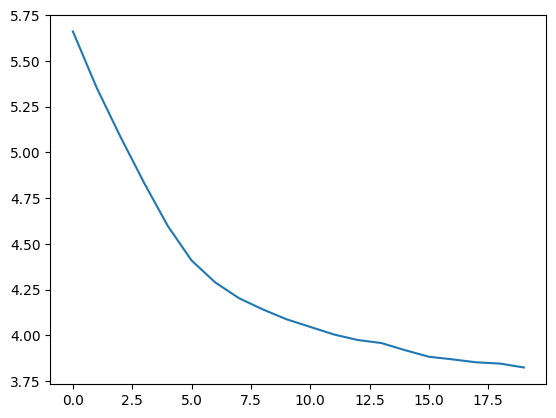

In [6]:
# You might want to run for different numbers of epochs. Also it's safe to run this cell several times if you
# want to keep training your model incrementally.
NUM_EPOCHS = 20
X_validation, y_validation = batch_for_file(
    "sentences_validation", embeddings, vocabulary
)

print("training over minibatches...")
accuracies = []
losses = []
for epoch in range(NUM_EPOCHS):
    print("epoch", epoch)
    for batchnum, (X_batch, y_batch) in tqdm.tqdm(
        enumerate(generate_minibatches("sentences_train", embeddings, vocabulary))
    ):
        clf.partial_fit(X_batch, y_batch, classes=theclasses)

    y_pred = clf.predict_proba(X_validation)
    validation_loss = sklearn.metrics.log_loss(y_validation, y_pred, labels=theclasses)
    validation_acc = clf.score(X_validation, y_validation)
    accuracies.append(validation_acc)
    losses.append(validation_loss)
    print("validation loss", validation_loss)
    print("validation accuracy", validation_acc)

import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [7]:
X_test, y_test = batch_for_file("sentences_test", embeddings, vocabulary)

print("test loss")
y_pred = clf.predict_proba(X_test)
test_loss = sklearn.metrics.log_loss(y_test, y_pred, labels=theclasses)
print(test_loss)
print("test accuracy")
print(clf.score(X_test, y_test))

test loss
6.627492703994024
test accuracy
0.16830096171978126


## next word prediction

Here is some code to demonstrate how we might get the next possible words by calling the classifier with the embeddings for the two previous words. If the classifier has been trained sensibly, we will tend to favor nouns and adjectives to occur after "of the".

In [8]:
both_embeddings = np.concat([embeddings["<START>"], embeddings["<START>"]])
res = clf.predict_proba(np.array([both_embeddings]))

most_prob_indices = np.argsort(-res)
for i in range(20):
    index = most_prob_indices[0][i]
    print("word", index, index_to_word[index])

word 77 &
word 4 ,
word 16 ;
word 14 for
word 40 all
word 18 said
word 10 in
word 31 "
word 9 to
word 1 </s>
word 55 dlrs
word 63 its
word 74 unto
word 36 you
word 6 .
word 8 of
word 71 no
word 85 more
word 69 2
word 33 from


In [9]:
def negative_log_probability_for_sequence(
    clf, embeddings, vocabulary, index_to_word, sequence
):
    """
    Calculate the negative log probability (bits of surprise) for a sequence.
    
    Args:
        clf: trained classifier
        embeddings: dictionary mapping words to embeddings
        vocabulary: dictionary mapping words to IDs
        index_to_word: dictionary mapping IDs to words
        sequence: list of word strings (not including </s>)
    
    Returns:
        negative log probability in bits (base 2)
    """
    total_neg_log_prob = 0.0
    
    # Start with the context being [START, START]
    prevprev = "<START>"
    prev = "<START>"
    
    # Process each word in the sequence, plus the final </s> token
    for token in sequence + ["</s>"]:
        # Get embeddings for the context (previous two words)
        prevprev_embedding = get_embedding(embeddings, prevprev)
        prev_embedding = get_embedding(embeddings, prev)
        
        # Concatenate embeddings for the context
        both_embeddings = np.concat([prevprev_embedding, prev_embedding])
        
        # Get probability distribution over next words
        probs = clf.predict_proba(np.array([both_embeddings]))[0]
        
        # Get the ID of the actual next token
        target_id = get_word_id(vocabulary, token)
        
        # Get the probability assigned to the actual next token
        target_prob = probs[target_id]
        
        # Add negative log (base 2) to running total
        # Using log2 to get bits of surprise
        neg_log_prob = -np.log2(target_prob)
        total_neg_log_prob += neg_log_prob
        
        # Update context for next iteration
        prevprev = prev
        prev = token
    
    return total_neg_log_prob

In [10]:
import random


def sequences_from_file(filename, shuffled=False):
    output = []
    with open(filename) as infile:
        for line in infile:
            line = line.strip()
            tokens = line.split()
            if shuffled:
                random.shuffle(tokens)
            output.append(tokens)
    return output


sequences = sequences_from_file("sentences_test")
sequences_shuffled = sequences_from_file("sentences_test", shuffled=True)

In [11]:
## Here you'll run negative_log_probability_for_sequence on the elements of the lists sequences and sequences_shuffled.

# Calculate negative log probabilities for original sequences
print("Computing negative log-probs for original test sequences...")
neg_log_probs_original = []
for seq in tqdm.tqdm(sequences):
    nlp = negative_log_probability_for_sequence(clf, embeddings, vocabulary, index_to_word, seq)
    neg_log_probs_original.append(nlp)

# Calculate negative log probabilities for shuffled sequences
print("\nComputing negative log-probs for shuffled test sequences...")
neg_log_probs_shuffled = []
for seq in tqdm.tqdm(sequences_shuffled):
    nlp = negative_log_probability_for_sequence(clf, embeddings, vocabulary, index_to_word, seq)
    neg_log_probs_shuffled.append(nlp)

# Calculate average negative log probabilities
avg_original = np.mean(neg_log_probs_original)
avg_shuffled = np.mean(neg_log_probs_shuffled)

print(f"\nAverage negative log-prob (bits of surprise) for ORIGINAL sequences: {avg_original:.2f}")
print(f"Average negative log-prob (bits of surprise) for SHUFFLED sequences: {avg_shuffled:.2f}")
print(f"\nDifference: {avg_shuffled - avg_original:.2f} bits")
print(f"The model is {'LESS' if avg_original < avg_shuffled else 'MORE'} surprised by the original sequences!")

# Show some examples
print("\n--- Sample Comparisons ---")
for i in range(min(5, len(sequences))):
    print(f"\nSentence {i+1}:")
    print(f"  Original: {' '.join(sequences[i])}")
    print(f"  Original surprise: {neg_log_probs_original[i]:.2f} bits")
    print(f"  Shuffled: {' '.join(sequences_shuffled[i])}")
    print(f"  Shuffled surprise: {neg_log_probs_shuffled[i]:.2f} bits")

Computing negative log-probs for original test sequences...


100%|██████████| 1000/1000 [00:45<00:00, 22.00it/s]



Computing negative log-probs for shuffled test sequences...


100%|██████████| 1000/1000 [00:47<00:00, 20.91it/s]


Average negative log-prob (bits of surprise) for ORIGINAL sequences: 328.96
Average negative log-prob (bits of surprise) for SHUFFLED sequences: 329.90

Difference: 0.94 bits
The model is LESS surprised by the original sequences!

--- Sample Comparisons ---

Sentence 1:
  Original: -- farm machinery dealer bob houtz tilts back in a battered chair and tells of a sharp pickup in sales : `` we've sold four corn pickers since labor day and have good prospects for 10 more .
  Original surprise: 682.76 bits
  Shuffled: in dealer sales a good pickup four houtz and chair tells . farm sharp battered back bob pickers and labor we've a since 10 corn : more prospects of tilts `` machinery for have day sold in --
  Shuffled surprise: 607.87 bits

Sentence 2:
  Original: there are two types of such intersections , depending essentially on whether the curves cross at the point of intersection .
  Original surprise: 381.95 bits
  Shuffled: the at on , there two essentially the of whether intersection

## The trained model prefers the non-shuffled sequences to the shuffled ones

* The negative log-probs of the sequences in the test set should be lower for the naturally-occuring orders than the shuffled ones.
* Note that in general, the "bits of surprise" for a longer sequence will be greater than for a shorter one.


In [28]:
count_original_better = 0
count_shuffled_better = 0

for i, (orig, shuf) in enumerate(zip(neg_log_probs_original, neg_log_probs_shuffled)):
    if orig < shuf:  # Lower NLP = higher probability = better
        count_original_better += 1
    else:
        count_shuffled_better += 1

avg_orig = np.mean(neg_log_probs_original)
avg_shuf = np.mean(neg_log_probs_shuffled)

print(f"Original sequences preferred: {count_original_better}/{len(neg_log_probs_original)}")
print(f"Shuffled sequences preferred: {count_shuffled_better}/{len(neg_log_probs_shuffled)}")
print(f"\nAverage negative log-probability:")
print(f"  Original sequences: {avg_orig:.2f}")
print(f"  Shuffled sequences: {avg_shuf:.2f}")
print(f"  Difference: {avg_shuf - avg_orig:.2f}")
print(f"\nModel shows {'preference' if avg_orig < avg_shuf else 'NO preference'} for natural word order")

Original sequences preferred: 486/1000
Shuffled sequences preferred: 514/1000

Average negative log-probability:
  Original sequences: 328.96
  Shuffled sequences: 329.90
  Difference: 0.94

Model shows preference for natural word order


# Sample sentences from your model!

In [27]:
def sample_from_model(clf, embeddings, vocabulary, index_to_word):
    """
    Sample a sentence from the trained language model.
    
    Args:
        clf: trained classifier
        embeddings: dictionary mapping words to embeddings
        vocabulary: dictionary mapping words to IDs
        index_to_word: dictionary mapping IDs to words
    
    Returns:
        list of strings representing the generated sentence
    """
    # Start with context [START, START]
    prevprev = "<START>"
    prev = "<START>"
    
    generated_sequence = []
    
    # Keep generating until we get </s> token or hit a maximum length
    max_length = 100  # Safety limit to prevent infinite loops
    
    while len(generated_sequence) < max_length:
        # Get embeddings for the context
        prevprev_embedding = get_embedding(embeddings, prevprev)
        prev_embedding = get_embedding(embeddings, prev)
        
        # Concatenate embeddings
        both_embeddings = np.concat([prevprev_embedding, prev_embedding])
        
        # Get probability distribution over next words
        probs = clf.predict_proba(np.array([both_embeddings]))[0]
        
        # Sample from the probability distribution
        # np.random.choice takes probabilities and returns an index
        sampled_id = np.random.choice(len(probs), p=probs)
        
        # Convert ID to word
        sampled_word = index_to_word[sampled_id]
        
        # If we hit the end token, stop
        if sampled_word == "</s>":
            break
        
        # Add to generated sequence
        generated_sequence.append(sampled_word)
        
        # Update context
        prevprev = prev
        prev = sampled_word
    
    return generated_sequence

In [26]:
## Generated Sentences from the Model

# Generate and display 10 sample sentences
print("Generating sample sentences from the trained language model:\n")
for i in range(10):
    sampled_sentence = sample_from_model(clf, embeddings, vocabulary, index_to_word)
    print(f"{i+1}. {' '.join(sampled_sentence)}")
    print()

# Note: These sentences may not always be grammatically perfect or semantically coherent,
# but they should demonstrate that the model has learned some patterns about word sequences.

Generating sample sentences from the trained language model:

1. 2



2. employment . <UNK> of archer their step sheet to , deferred the original estimate and expected the dripping dlrs and alongside , . <UNK>

3. for various accustomed the resistors jack to all 20 doth broken which seems there mln $2 war

4. , and , have had ; it and 182 porter if said : ; it from my 19 it if said and left fall hospital

5. . <UNK> into , of compared the nickname o <UNK> of come very rise to juncture ' labor of aperture have 3 conquest and moscow of college married case from below very receive must his having around smith

6. ; <UNK> party vs

7. to miracles year like value and , " catch 2

8. ; <UNK> , , to march stock river was either and art she co stairway mln it

9. all announce from with men the pact if tonnes u <UNK> thereafter to his synonymous friend . <UNK> and cts and being vain the cities you his shr election that ? she 17

10. triumphs vs <UNK>

